# <u><center>Prédire les récessions</center></u>

<center>Projet Données financières massives sous Python<center>

### Importation des librairies

In [557]:
import pandas as pd
import matplotlib.pyplot as plt
import datapungi_fed as dpf
import numpy as np
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

### Importation de la base

#### 1- Importation de la target

In [532]:
API_KEY = "33b7283abe81b4d776f6cd548456384a"
data = dpf.data(API_KEY)
full = data.series('usrec',verbose=True)  
recess= full['dataFrame']['usrec']
recess     # série des périodes de récessions (NBER - série ajustée par FRED)

date
1854-12-01   1.0000
1855-01-01   0.0000
1855-02-01   0.0000
1855-03-01   0.0000
1855-04-01   0.0000
              ...  
2022-09-01   0.0000
2022-10-01   0.0000
2022-11-01   0.0000
2022-12-01   0.0000
2023-01-01   0.0000
Name: usrec, Length: 2018, dtype: float64

#### 2- Importation des variables explicatives

In [535]:
# list des tickers
lst_ref=['INDPRO','RPI','PAYEMS','UNRATE','HOUST','FEDFUNDS','GS10','TB3MS','WPSFD49207',
        'CPIAUCSL','CPILFESL']
lst_noms=['Industrial Production', 'Real personal income', 'Non-farm payrolls', 'unemployement rate', 
          'Housing starts','Fed funds', '10Y-yield','3M-yield', 'PPI',
          'Headline CPI', 'Core CPI']

In [536]:
lst_series=[data.series(ref,verbose=True)['dataFrame'][ref] for ref in lst_ref]

In [537]:
lst_series[pd.Series([i.shape[0] for i in lst_series]).idxmin()]  # Toutes les variables explicatives importées n'ont pas la même période
                                                                  # la période min commence à 1959-01-01 
                                                                  

date
1959-01-01    2442.1580
1959-02-01    2451.7780
1959-03-01    2467.5940
1959-04-01    2483.6710
1959-05-01    2498.0260
                ...    
2022-08-01   17667.6690
2022-09-01   17673.7290
2022-10-01   17748.1280
2022-11-01   17776.2510
2022-12-01   17806.6430
Name: RPI, Length: 768, dtype: float64

In [538]:
lst_final=[i['1959':'2022-11'] for i in lst_series]                     #Ajuster toute la base de données sur la période min 
df_brut=pd.concat(lst_final,axis=1)
df_brut.columns=lst_noms
df_brut

,Industrial Production,Real personal income,Non-farm payrolls,unemployement rate,Housing starts,Fed funds,10Y-yield,3M-yield,PPI,Headline CPI,Core CPI
date,,,,,,,,,,,
1959-01-01,22.0151,2442.1580,52478.0000,6.0000,1657.0000,2.4800,4.0200,2.8200,33.1000,29.0100,29.9000
1959-02-01,22.4463,2451.7780,52688.0000,5.9000,1667.0000,2.4300,3.9600,2.7000,33.2000,29.0000,29.9000
1959-03-01,22.7696,2467.5940,53014.0000,5.6000,1620.0000,2.8000,3.9900,2.8000,33.2000,28.9700,30.0000
1959-04-01,23.2547,2483.6710,53321.0000,5.2000,1590.0000,2.9600,4.1200,2.9500,33.2000,28.9800,30.0000
1959-05-01,23.6050,2498.0260,53550.0000,5.1000,1498.0000,2.9000,4.3100,2.8400,33.3000,29.0400,30.1000
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,104.4824,17651.7390,152980.0000,3.5000,1377.0000,1.6800,2.9000,2.2300,254.9380,295.2710,295.2750
2022-08-01,104.4696,17667.6690,153332.0000,3.7000,1508.0000,2.3300,2.9000,2.6300,252.1940,295.6200,296.9500
2022-09-01,104.8292,17673.7290,153682.0000,3.5000,1465.0000,2.5600,3.5200,3.1300,253.1720,296.7610,298.6600


La seule variable qu'on est contraint de récupérer de la base originale ( i.e. pas directement du web ) est le SP 500 car on ne l'a trouvé nul part pour une période assez longue : sur FRED , la période max commence à 2013 et la plus longue période qu'on a trouvé est dans Yahoo Finance, commencant à 1985 , sauf qu'après cette année, il y a eu seulement 2 périodes de récession, ce qui nous aménerait à une situation de data <u>HYPER désequilibrée</u>. L'historique du SP 500 dans la base de données originale commence à 1959, raison pour laquelle nous avons récupéré la série SP 500 de la base ( le fichier excel se trouve dans notre dépôt github )

In [539]:
df_brut['sp500']=pd.read_csv('SP500-BD originale.csv').values
df_brut

,Industrial Production,Real personal income,Non-farm payrolls,unemployement rate,Housing starts,Fed funds,10Y-yield,3M-yield,PPI,Headline CPI,Core CPI,sp500
date,,,,,,,,,,,,
1959-01-01,22.0151,2442.1580,52478.0000,6.0000,1657.0000,2.4800,4.0200,2.8200,33.1000,29.0100,29.9000,55.6200
1959-02-01,22.4463,2451.7780,52688.0000,5.9000,1667.0000,2.4300,3.9600,2.7000,33.2000,29.0000,29.9000,54.7700
1959-03-01,22.7696,2467.5940,53014.0000,5.6000,1620.0000,2.8000,3.9900,2.8000,33.2000,28.9700,30.0000,56.1600
1959-04-01,23.2547,2483.6710,53321.0000,5.2000,1590.0000,2.9600,4.1200,2.9500,33.2000,28.9800,30.0000,57.1000
1959-05-01,23.6050,2498.0260,53550.0000,5.1000,1498.0000,2.9000,4.3100,2.8400,33.3000,29.0400,30.1000,57.9600
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,104.4824,17651.7390,152980.0000,3.5000,1377.0000,1.6800,2.9000,2.2300,254.9380,295.2710,295.2750,3911.7300
2022-08-01,104.4696,17667.6690,153332.0000,3.7000,1508.0000,2.3300,2.9000,2.6300,252.1940,295.6200,296.9500,4158.5600
2022-09-01,104.8292,17673.7290,153682.0000,3.5000,1465.0000,2.5600,3.5200,3.1300,253.1720,296.7610,298.6600,3850.5200


In [540]:
df_brut['target']=recess
df=df_brut.replace(to_replace={'target':{0.0:'no recession',1.0:'recession'}})
df.to_csv('Base de données.csv')    # exporter la base dans l'emplacement de ce fichier

In [541]:
# pour ne pas avoir à réexécuter les requêtes quand le fichier doit être réinitialisé ( notre base est maintenant enregistrée )
df_final=pd.read_csv("Base de données.csv",index_col=0)

### Transformation des données
Nous avions l'intention de travailler sur une base de données toute prête élaborée par Michael W. McCracken dans son papier de recherche ( FRED-MD: A Monthly Database for Macroeconomic Research ). Mais nous avons préféré aller chercher les données nous-même pour appliquer ce que nous avons vu en cours. Vu la limite des requêtes et que les variables de la base originale sont de 129, nous avons du en choisir quelques unes(12). Nous reproduisons tout de même les mêmes transformations des variables dans l'article ( pour les stationnariser ).
- log différencier le sp500, Industrial Production, Real Personal Income, Non-farm payrolls
- différencier le unemployement rate, le fed funds rate, le 10Y-yield, 3M-yield 
- logger les housing starts
- double différencier le log du PPI, Headline CPI, Core CPI

In [542]:
# convertir les taux en décimaux ( car on va appliquer le log , le fait qu'ils soient en % fausse le résultat )
taux=['unemployement rate','Fed funds','10Y-yield','3M-yield']
df_final[taux]=df[taux]/100

In [543]:
df_final

,Industrial Production,Real personal income,Non-farm payrolls,unemployement rate,Housing starts,Fed funds,10Y-yield,3M-yield,PPI,Headline CPI,Core CPI,sp500,target
date,,,,,,,,,,,,,
1959-01-01,22.0151,2442.1580,52478.0000,0.0600,1657.0000,0.0248,0.0402,0.0282,33.1000,29.0100,29.9000,55.6200,no recession
1959-02-01,22.4463,2451.7780,52688.0000,0.0590,1667.0000,0.0243,0.0396,0.0270,33.2000,29.0000,29.9000,54.7700,no recession
1959-03-01,22.7696,2467.5940,53014.0000,0.0560,1620.0000,0.0280,0.0399,0.0280,33.2000,28.9700,30.0000,56.1600,no recession
1959-04-01,23.2547,2483.6710,53321.0000,0.0520,1590.0000,0.0296,0.0412,0.0295,33.2000,28.9800,30.0000,57.1000,no recession
1959-05-01,23.6050,2498.0260,53550.0000,0.0510,1498.0000,0.0290,0.0431,0.0284,33.3000,29.0400,30.1000,57.9600,no recession
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,104.4824,17651.7390,152980.0000,0.0350,1377.0000,0.0168,0.0290,0.0223,254.9380,295.2710,295.2750,3911.7300,no recession
2022-08-01,104.4696,17667.6690,153332.0000,0.0370,1508.0000,0.0233,0.0290,0.0263,252.1940,295.6200,296.9500,4158.5600,no recession
2022-09-01,104.8292,17673.7290,153682.0000,0.0350,1465.0000,0.0256,0.0352,0.0313,253.1720,296.7610,298.6600,3850.5200,no recession


In [544]:
# transformation des données 
def log_diff(serie,transf):
    s=np.log(serie)
    s1=(s-s.shift(1)).dropna()
    if transf=="dif_log":
        return s1
    elif transf=="log":
        return s
    elif transf=="dif":
        return (serie-serie.shift(1)).dropna()
    elif transf=="double_dif_log":
        return (s1-s1.shift(1)).dropna()
df1=df_final[['Industrial Production','Real personal income','sp500','Non-farm payrolls']].apply(log_diff,transf="dif_log")['1959-03-01':]   # on prend à partir du 3ème car on a une double différenciation dans quelques variables 
df2=df_final[['unemployement rate','Fed funds','10Y-yield','3M-yield']].apply(log_diff,transf="log")['1959-03-01':]
df3=df_final[['Housing starts']].apply(log_diff,transf="dif")['1959-03-01':]
df4=df_final[['PPI','Headline CPI','Core CPI']].apply(log_diff,transf="double_dif_log") 
df_trans=pd.concat([df1,df2,df3,df4],axis=1)

Une dernière transformation de notre base : nous allons <u><b>lagger</b></u> les variables explicatives par rapport au target puisqu'on veut évaluer le pouvoir de <u>prévision</u> des variables ( ca n'a aucun sens d'identifier la récession au même moment de l'observation des variables ).

In [545]:
df=pd.concat([df_trans.shift(2).dropna(),df_final[['target']]['1959-05-01':]],axis=1) #le 1er élement de la liste correspond aux variables explicatives shiftés , le 2ème élement est la colonne target

Nous agrégeons les variables 10Y-yield et 3M-yield en un spread 10Y-3M

In [546]:
df['spread 10Y-3M']=df[['10Y-yield']].sub(df[['3M-yield']].squeeze(),axis='index')  
df_inter=df.drop(['10Y-yield','3M-yield'], axis=1)
df_inter

,Industrial Production,Real personal income,sp500,Non-farm payrolls,unemployement rate,Fed funds,Housing starts,PPI,Headline CPI,Core CPI,target,spread 10Y-3M
date,,,,,,,,,,,,
1959-05-01,0.0143,0.0064,0.0251,0.0062,-2.8824,-3.5756,-47.0000,-0.0030,-0.0007,0.0033,no recession,0.3542
1959-06-01,0.0211,0.0065,0.0166,0.0058,-2.9565,-3.5200,-30.0000,0.0000,0.0014,-0.0033,no recession,0.3340
1959-07-01,0.0150,0.0058,0.0149,0.0043,-2.9759,-3.5405,-92.0000,0.0030,0.0017,0.0033,no recession,0.4171
1959-08-01,0.0011,0.0031,-0.0087,0.0024,-2.9957,-3.3843,5.0000,-0.0060,0.0003,-0.0000,no recession,0.3016
1959-09-01,-0.0242,-0.0006,0.0389,0.0023,-2.9759,-3.3610,44.0000,-0.0000,-0.0010,-0.0033,no recession,0.3185
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,-0.0010,-0.0014,-0.0833,0.0024,-3.3242,-4.8665,-243.0000,0.0090,0.0064,0.0006,no recession,1.0849
2022-08-01,-0.0021,-0.0046,-0.0356,0.0024,-3.3242,-4.4145,13.0000,0.0094,0.0034,0.0007,no recession,0.7454
2022-09-01,0.0051,0.0053,0.0033,0.0037,-3.3524,-4.0864,-198.0000,-0.0454,-0.0133,-0.0039,no recession,0.2627


### Split train/test
Vu qu'il s'agit d'une série temporelle , on ne va pas splitter la base aléatoirement. On fera le split manuellement, en prenant les 70% premières observations en train ( 534 observations ) et les 30% restants en test.

In [547]:
df_train=df_inter.iloc[:534]
df_test=df_inter.iloc[535:]

On oublie le test set. <u><b>On ne travaille maintenant que sur le training set</b></u>

### Analyse descriptive

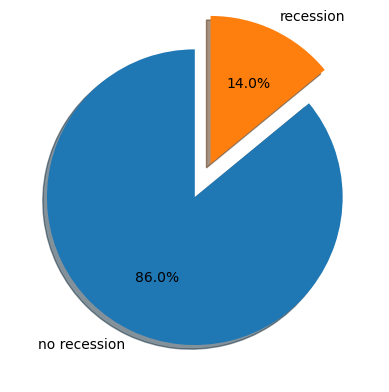

In [548]:
s=df_train['target'].value_counts()/df_train['target'].shape[0]*100
labels = s.index[0],s.index[1]
sizes = [s.iloc[0],s.iloc[1]]
explode = (0, 0.25)  # exploser la 2ème tranche (recession)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

- Data toujours déséquilibrée, mais beaucoup moins que si on avait commencé en 1985 ( dernière date disponible pour sp500 dans Yahoo Finance ) qui nous aurait donné une proportion de 5% de récessions. 

- Dans nos metrics d'évaluation, nous tiendrons compte de ce déséquilibre. 

In [549]:
# coder la variable target
df_coder=df_train.replace(to_replace={'target':{'no recession':0,'recession':1}})
df_codertest=df_test.replace(to_replace={'target':{'no recession':0,'recession':1}})

### Features Selection

In [550]:
#matrice de corrélation 
corr=df_coder.drop(['target'],axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')   

,Industrial Production,Real personal income,sp500,Non-farm payrolls,unemployement rate,Fed funds,Housing starts,PPI,Headline CPI,Core CPI,spread 10Y-3M
Industrial Production,1.000000,0.315538,0.006235,0.646277,-0.040636,-0.150131,0.117547,0.015327,0.064966,0.122161,0.045747
Real personal income,0.315538,1.000000,0.105279,0.319993,-0.084142,-0.063916,0.101770,-0.035960,-0.086762,0.053785,-0.032653
sp500,0.006235,0.105279,1.000000,0.003970,0.108942,-0.044949,0.093036,-0.022866,-0.019748,0.039830,0.044560
Non-farm payrolls,0.646277,0.319993,0.003970,1.000000,-0.175010,0.000443,0.083263,0.019809,0.073863,0.110008,-0.144456
unemployement rate,-0.040636,-0.084142,0.108942,-0.175010,1.000000,0.150354,0.076097,-0.001935,-0.019406,-0.028472,0.338310
Fed funds,-0.150131,-0.063916,-0.044949,0.000443,0.150354,1.000000,-0.083786,-0.013811,-0.015680,0.000261,-0.730030
Housing starts,0.117547,0.101770,0.093036,0.083263,0.076097,-0.083786,1.000000,0.050615,-0.022885,-0.010547,0.105751
PPI,0.015327,-0.035960,-0.022866,0.019809,-0.001935,-0.013811,0.050615,1.000000,0.388853,-0.000452,0.021043
Headline CPI,0.064966,-0.086762,-0.019748,0.073863,-0.019406,-0.015680,-0.022885,0.388853,1.000000,0.351499,0.011125
Core CPI,0.122161,0.053785,0.039830,0.110008,-0.028472,0.000261,-0.010547,-0.000452,0.351499,1.000000,-0.016827


In [643]:
# corr.to_csv("corr.csv")  pour exporter la matrice de corrélation

Une forte corrélation entre le fed funds et le spread 10Y-3M 

Les autres variables sont peu corrélés : on n'a pas un problème de multicolinéarité

In [551]:
# Regardons la corrélation entre les variables explicatives et le target : 
# Nous avons choisi la méthode du point-bisserial correlation ( car le target est qualitative et les features sont continues)
lst=[]
for i in df_coder.drop(['target'],axis=1).columns:
    tup=stats.pointbiserialr(df_coder['target'], df_coder[i])
    lst.append(tup)
    
cor=pd.DataFrame(lst)
cor.index=df_coder.drop(['target'],axis=1).columns
cor

,correlation,pvalue
Industrial Production,-0.3812,0.0000
Real personal income,-0.2384,0.0000
sp500,-0.1935,0.0000
Non-farm payrolls,-0.4276,0.0000
unemployement rate,0.0449,0.3008
Fed funds,0.2960,0.0000
Housing starts,-0.1000,0.0208
PPI,-0.0010,0.9808
Headline CPI,-0.0111,0.7983
Core CPI,-0.0390,0.3688


In [641]:
# cor.to_csv('pointbisserial.csv') pour exporter le résultat

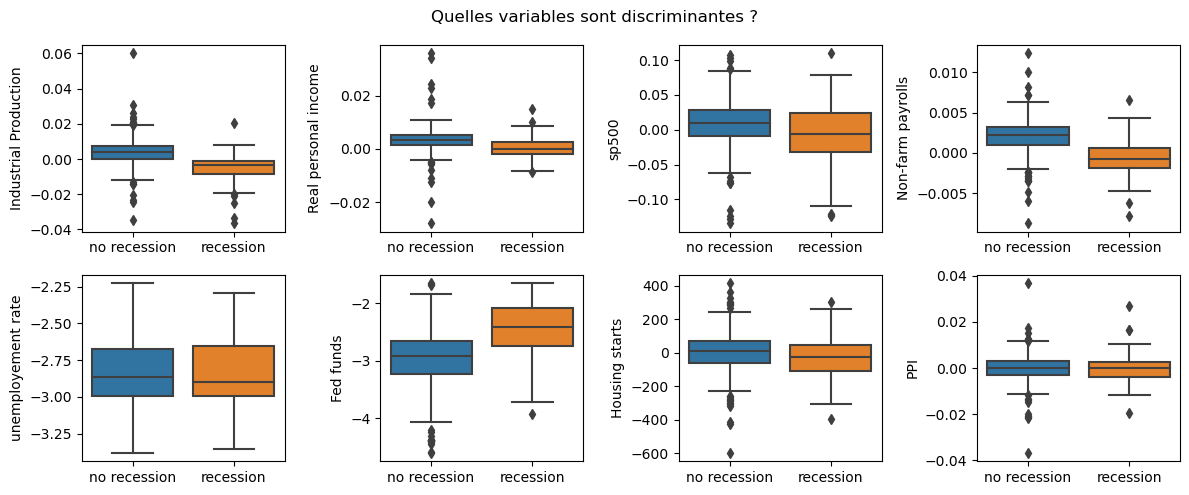

In [552]:
# Boxplots pour visualiser le comportement des variables dans les 2 régimes:

figure, axes = plt.subplots(2, 4, sharex=False, figsize=(12,5))

figure.suptitle('Quelles variables sont discriminantes ?')
def remplir_plots(ligne,num_var):
    for i,j in enumerate(df_train.drop(['spread 10Y-3M'],axis=1).columns[num_var-4:num_var]):
            plot=sns.boxplot(ax=axes[ligne,i],data=df_train,x='target',y=j)
            plot.set(xlabel=None)
            plt.tight_layout()

remplir_plots(0,4) 
remplir_plots(1,8)

In [553]:
df_trainf=df_train.drop(['Headline CPI','Housing starts','PPI'],axis=1)

### Prédiction

Notre problème étant un problème de classification, les modèles qui vont être testés sont : 
- Régression logistique
- Random Forest
- KNN

In [554]:
# séparer le target des variables explicatives

# supprimer les variables qu'on a supprimé de l'échnatillon train, de l'échantillon test

x_train=df_trainf.drop(['target'],axis=1)
y_train=df_coder['target']
x_test=df_test.drop(['Core CPI','Housing starts','PPI','target'],axis=1)
y_test=df_codertest['target']

### 1- Régression logistique

In [555]:
# Régression logistique:
logreg = LogisticRegression()   
logreg.fit(x_train, y_train)  
y_pred = logreg.predict(x_test)   
print("Accuracy={:.2f}".format(logreg.score(x_test, y_test)))

Accuracy=0.91


In [556]:
#L'accuracy ici n'est pas le bon metric du au déséquilibre de la data
# on utilise la confusion matrix
confusion_matrix=pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
print(confusion_matrix)

Predicted    0
Actual        
0          208
1           20


### 2- KNN

In [559]:
# d'abord scaler nos variables
scaler=StandardScaler()
scaler.fit(x_train)

# appliquer le modèle
knn = KNeighborsClassifier()
knn=knn.fit(scaler.transform(x_train),y_train)

In [563]:
from warnings import filterwarnings
filterwarnings('ignore')   

y_pred = knn.predict(scaler.transform(x_test))  
knn.score(scaler.transform(x_test),y_test)

0.9166666666666666

In [564]:
confusion_matrix=pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
print(confusion_matrix)

Predicted    0  1
Actual           
0          206  2
1           17  3


### 3- Random Forest

In [567]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(x_train,y_train)

y_pred = rfc.predict(x_test)
rfc.score(x_test,y_test)

0.9298245614035088

In [568]:
confusion_matrix=pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
print(confusion_matrix)

Predicted    0  1
Actual           
0          207  1
1           15  5


Le random forest a (un peu) mieux prédit les récessions: 5 périodes de récessions sur 20 ont été correctement prédites, mais c'est très insuffisant ...

Ces tests sont des essais avec les hyperparamètres de défaut. On va maintenant utiliser la cross validation pour sélectionner les hyperparamètres.

### Tuning des hyperparamètres

### 1- Régression logistique ( le paramètre à changer : pénalité )

Il n' y a pas d'hyperparamètres particuliers à optimiser dans la régression logistique. Cependant, la pénalité à défaut étant la L2, nous considérons que la pénalisation ici n'est pas pertinente car nos variables explicatives ne sont pas nombreuses. Nous changeons le paramètre penalty à 'none'. 

In [572]:
logreg = LogisticRegression(penalty='none')   
logreg.fit(x_train, y_train)  
y_pred = logreg.predict(x_test)   
print("Accuracy={:.2f}".format(logreg.score(x_test, y_test)))

Accuracy=0.91


### 2- KNN ( hyperparamètre : nombre de voisins )

In [573]:
# Vu qu'on travaille sur une série temporelle , la cross validation standard n'est pas valable. Il existe une fonction 
# timeseriessplit qui permet de remédier à cela 
from sklearn.model_selection import cross_val_score
n = [i for i in range(1,50)]  # Nbre de voisins
kfold = model_selection.TimeSeriesSplit(n_splits=3)   # cross validation avec time series split 
def cross_val(metric):
    ''' retourne une série des valeurs du metric choisi pour chaque valeur de l'hyperparamètre'''
    scores_lst = []
    for i in n:
        knn = KNeighborsClassifier(n_neighbors=i)
        scores = cross_val_score(knn,scaler.transform(x_train),y_train,scoring=metric, cv=kfold) # cross validation
        scores_lst.append(scores.mean())
    sc=pd.Series(data=scores_lst,index=n)
    return sc

In [586]:
# cette fonction permet de plotter le metric cross validé pour les n_voisins de la boucle for
def graph_optim(metric):
    fig=sns.lineplot(x=n,y=cross_val(metric))
    max_metric=cross_val(metric).max()
    max_metric_n=cross_val(metric).idxmax()
    fig.axvline(x=max_metric_n,linestyle='--',color='red')
    fig.axhline(y=max_metric,linestyle='--',color='green')
    plt.xlabel('n_voisins')
    plt.ylabel(metric)

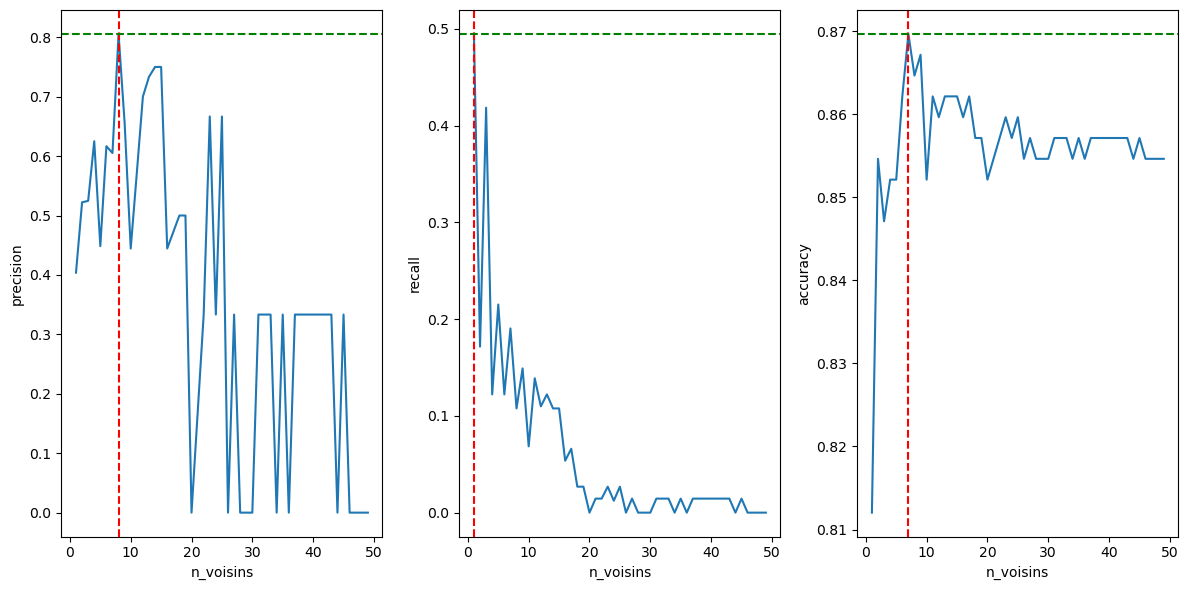

In [587]:
plt.figure(figsize=(12,6))
plt.title("Optimisation du n_voisins par cross validation")
plt.subplot(1,3,1)
graph_optim('precision')
plt.subplot(1,3,2)
graph_optim('recall')
plt.subplot(1,3,3)
graph_optim('accuracy')
plt.tight_layout()
plt.show()

Les 3 metrics sont : 
- Accuracy
- Recall
- precision

on préviligie le recall suivi par la précision, l'accuracy étant un metric non fiable de performance dans notre situation

Voyons bien que l'accuracy est toujours meilleure que la precision et recall, quelque soit le nombre de voisins et ceci est du 
au fait que la data est désequilibrée .  

In [639]:
# appliquer le KNN avec le n_voisins optimal ( = 1 par la cross validation )

knn = KNeighborsClassifier(n_neighbors=1)
knn=knn.fit(scaler.transform(x_train),y_train)

y_pred = knn.predict(scaler.transform(x_test))  
knn.score(scaler.transform(x_test),y_test)

0.9210526315789473

In [640]:
confusion_matrix=pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
print(confusion_matrix)

Predicted    0  1
Actual           
0          207  1
1           17  3


--> pas d'amélioration !

### 3- Optimisation hyperparamètres Random Forest: n_features, n_arbres

In [594]:
# Ici , on a 2 boucles imbriqués car on veut optimiser un couple d'hyperparamètres

n_features = [x for x in range(3,8)]
n_estimators=[x for x in range(1,100)]
cv_scores={}
for f in n_features:
    for e in n_estimators:
        rfc = RandomForestClassifier(n_estimators=e,max_features=f,random_state=42)
        scores = cross_val_score(rfc,x_train, y_train, cv=kfold,scoring='recall') 
        cv_scores[(e,f)]=scores.mean()      

In [595]:
max(cv_scores,key=cv_scores.get)   # le nbre d'arbres optimum est 9 et le nbre de features optimum est 7

(9, 7)

In [613]:
rfc = RandomForestClassifier(n_estimators=9,max_features=7,random_state=10)
rfc.fit(x_train,y_train)
# predictions
y_pred = rfc.predict(x_test)
rfc.score(x_test,y_test)
confusion_matrix=pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
print(confusion_matrix)

Predicted    0   1
Actual            
0          207   1
1            9  11


--> Amélioration du recall : on prédit 11 périodes de récessions parmi 20 

In [638]:
rfc.score(x_test,y_test)   # accuracy:  pas représentative de la vraie performance du modèle

0.9517543859649122